## Import modules

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smformula
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Load the combined dataset and inspect it

In [2]:
os.chdir('C:\Apurva\Conservation Games\Games meta-analysis\Datasets\Data Gabon, Orkney, Madagascar and Kenya')
print(os.getcwd())

C:\Apurva\Conservation Games\Games meta-analysis\Datasets\Data Gabon, Orkney, Madagascar and Kenya


#### Drop rows where envProduction is NaN

In [3]:
# print number of rows in the dataset
data = pd.read_csv('combined6.csv', index_col=0)
print(len(data))
# drop rows where envProduction is NaN 
data.dropna(subset=['envProduction'], inplace=True)
print(len(data))

17083
14351


In [4]:
np.unique([x[:-2] for x in data.columns.values])

array(['Age', 'Education', 'Game', 'Gender', 'Rel1', 'Rel2', 'Rel3',
       'RespHOH', 'Roun', 'Treatmen', 'count', 'e', 'envProducti',
       'primary_farming', 'producti', 'subsi'], dtype='<U15')

#### Box-plots showing country-wise distribution of the environmental production outcome

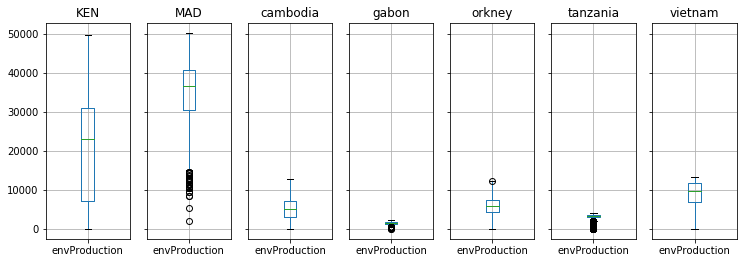

In [5]:
data[['envProduction', 'country']].groupby('country').boxplot(figsize=(12,4), layout=(1,7))
plt.show()

## Compute group statistics (mean, variance, min, max)

In [6]:
for col in ['Age', 'Education', 'Gender', 'RespHOH', 'primary_farming']:
    data[col+'_mean'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].mean(axis=1)
    #data[col+'_std'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].std(axis=1)
    data[col+'_var'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].var(axis=1)
    data[col+'_min'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].min(axis=1)
    data[col+'_max'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].max(axis=1)

data['rel_mean'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].mean(axis=1)
data['rel_var'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].var(axis=1)
data['rel_min'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].min(axis=1)
data['rel_max'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].max(axis=1)

#### One-hot encode the country column

In [7]:
# Get one hot encoding of country column
one_hot = pd.get_dummies(data['country'])
# Join the encoded dataframe
data = pd.concat([data, one_hot], axis=1)

In [8]:
data['GameID'] = data['GameID'].astype(str)

## Compute column-wise z-scores (separately for every subset of dataset)

In [9]:
col_list = ['Age_mean', 'Age_max', 'Age_min', 'Age_var',
            'Education_mean', 'Education_max', 'Education_min', 'Education_var',
            'Gender_mean', 'Gender_max', 'Gender_min', 'Gender_var',
            'primary_farming_mean', 'primary_farming_max', 'primary_farming_min', 'primary_farming_var',
            'rel_mean', 'rel_var', 'rel_min', 'rel_max', 'subsidy', 'envProduction', 'env', 'production']
for col in col_list:
    data['z_'+col] = data.groupby('country')[col].transform(lambda x: scale(x.astype(float)))

In [10]:
# define explanatory and response variables
explanatory_var = ['z_' + x for x in ['Age_mean', 'Age_max', 'Age_min', 'Age_var',
                  'Education_mean', 'Education_max', 'Education_min', 'Education_var',
                  'Gender_mean', 'Gender_max', 'Gender_min', 'Gender_var',
                  'primary_farming_mean', 'primary_farming_max', 'primary_farming_min', 'primary_farming_var',
                  'rel_mean', 'rel_var', 'rel_min', 'rel_max', 'subsidy']]#+['cambodia', 'gabon', 'orkney', 'tanzania', 'vietnam', 'KEN', 'MAD']

response_var = 'z_envProduction'

## Correlation heat-map for explanatory variables

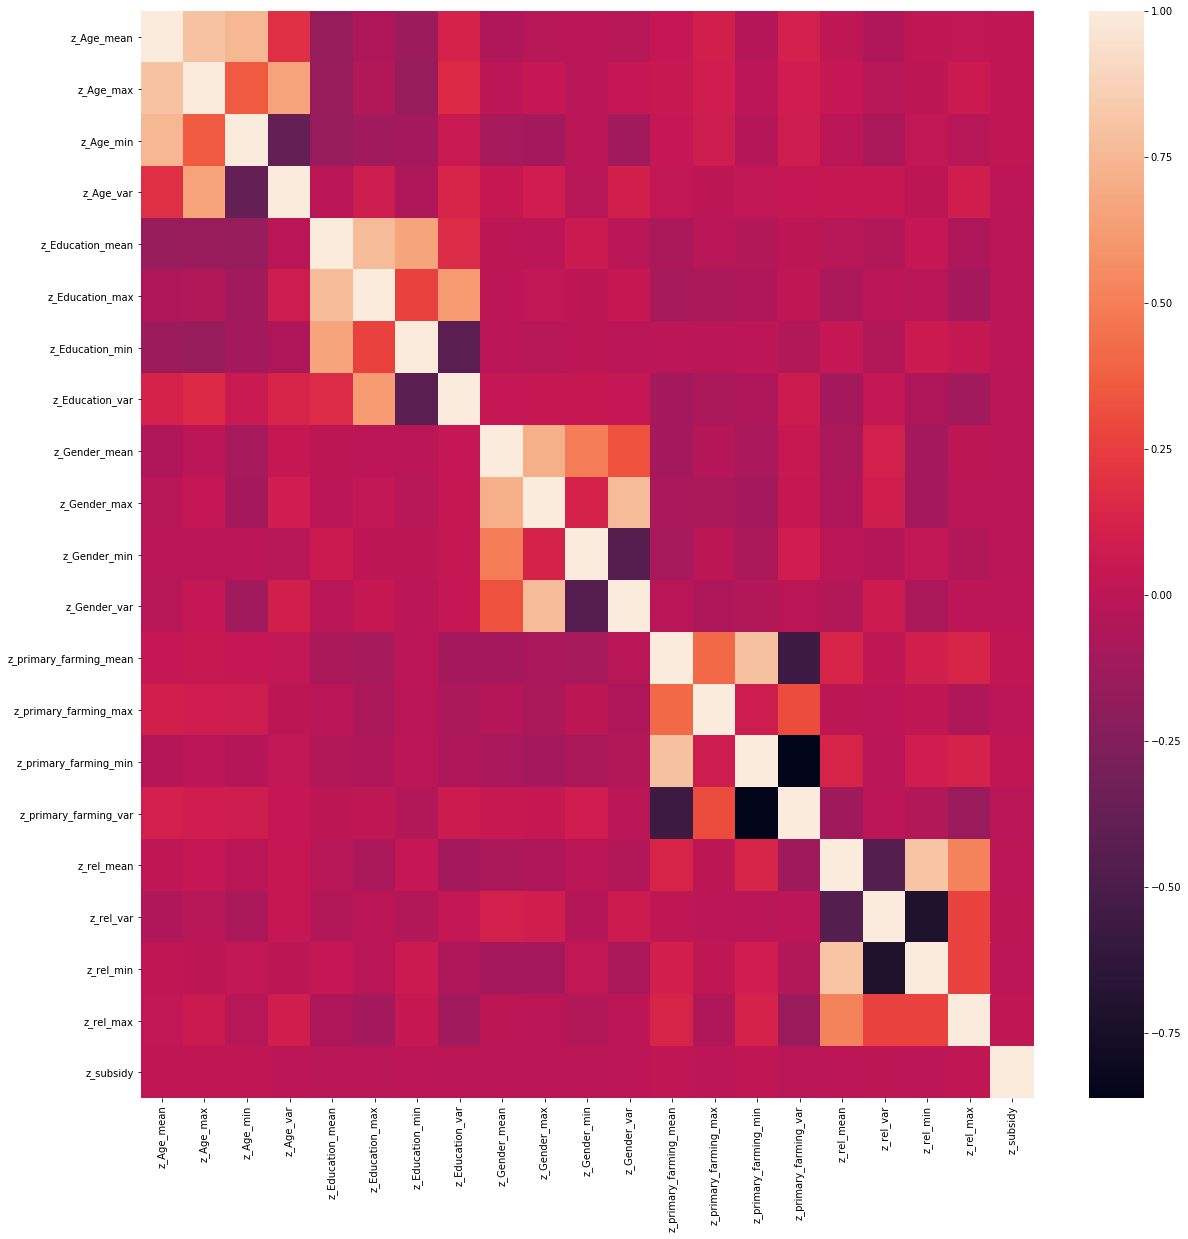

In [11]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data[explanatory_var].corr(), ax=ax)

#### Correlation between explanatory variables and response variable

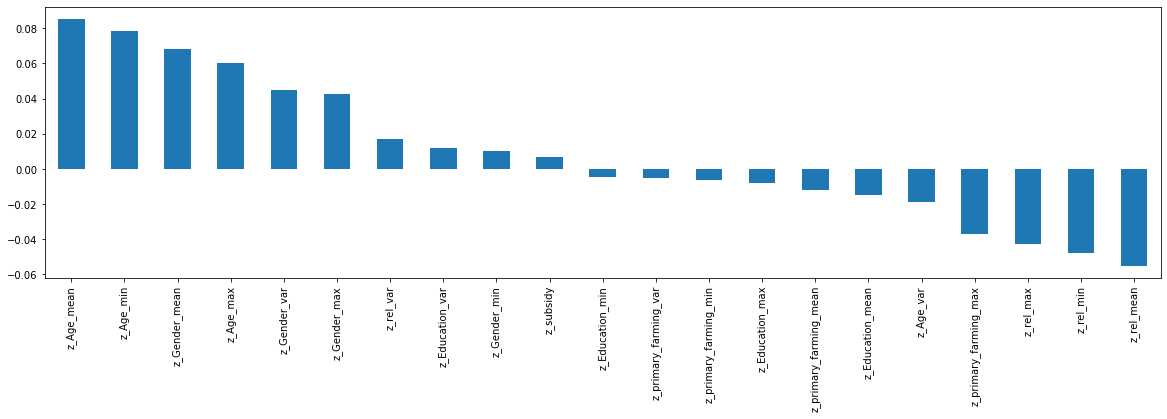

In [12]:
data[explanatory_var+[response_var]].corr()[response_var].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(20,5))

In [13]:
data[explanatory_var].corr().unstack().sort_values(ascending=False)[len(explanatory_var):]

z_rel_min              z_rel_mean                0.809215
z_rel_mean             z_rel_min                 0.809215
z_Age_max              z_Age_mean                0.802922
z_Age_mean             z_Age_max                 0.802922
z_primary_farming_min  z_primary_farming_mean    0.792055
                                                   ...   
z_primary_farming_var  z_primary_farming_mean   -0.566457
z_rel_var              z_rel_min                -0.715846
z_rel_min              z_rel_var                -0.715846
z_primary_farming_var  z_primary_farming_min    -0.861883
z_primary_farming_min  z_primary_farming_var    -0.861883
Length: 420, dtype: float64

## OLS regression analysis

In [14]:
# drop duplicate rows
print(len(data))
data.drop_duplicates(inplace=True)
print(len(data))

14351
14351


In [15]:
# write formula
formula = response_var + ' ~ '
for var in explanatory_var:
    formula += var + ' + '
formula = formula[:-3]

In [16]:
# define and fit model
model = smformula.ols(formula, data=data)
results = model.fit(cov_type='cluster', cov_kwds={'groups': data['GameID']})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        z_envProduction   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.048
Date:                Fri, 16 Jul 2021   Prob (F-statistic):              0.403
Time:                        04:17:48   Log-Likelihood:                -20182.
No. Observations:               14351   AIC:                         4.041e+04
Df Residuals:                   14329   BIC:                         4.057e+04
Df Model:                          21                                         
Covariance Type:              cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -7.67

In [17]:
pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0].to_csv('ep_all_c.csv')

#### ANOVA table (F-statistic and p-value)

In [18]:
table = sm.stats.anova_lm(results, typ=2) # Type 2 ANOVA DataFrame
print(table)

                              sum_sq       df         F    PR(>F)
z_Age_mean                  0.103544      1.0  0.106033  0.744865
z_Age_max                   1.065536      1.0  1.091153  0.296801
z_Age_min                   0.118431      1.0  0.121279  0.727822
z_Age_var                   1.526872      1.0  1.563580  0.211820
z_Education_mean            0.003356      1.0  0.003436  0.953281
z_Education_max             0.049854      1.0  0.051053  0.821348
z_Education_min             0.053597      1.0  0.054885  0.814882
z_Education_var             0.013739      1.0  0.014070  0.905636
z_Gender_mean               3.222569      1.0  3.300044  0.069972
z_Gender_max                2.472193      1.0  2.531628  0.112318
z_Gender_min                0.192161      1.0  0.196781  0.657554
z_Gender_var                1.644233      1.0  1.683763  0.195119
z_primary_farming_mean      0.175640      1.0  0.179862  0.671703
z_primary_farming_max       1.894274      1.0  1.939816  0.164407
z_primary_

## Visualizing coefficients and beta coefficients

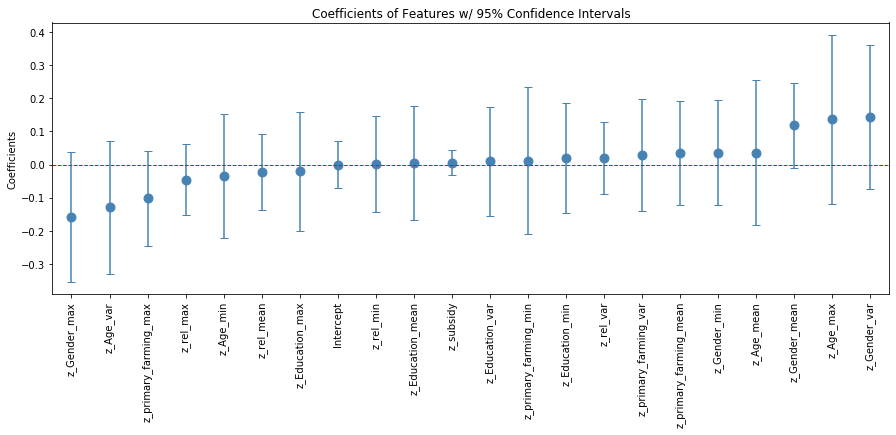

In [19]:
# Create dataframe of results summary 
coef_df = pd.DataFrame(results.summary().tables[1].data)
# Add column names
coef_df.columns = coef_df.iloc[0]
# Drop the extra row with column labels
coef_df=coef_df.drop(0)
# Set index to variable names 
coef_df = coef_df.set_index(coef_df.columns[0])
# Change datatype from object to float
coef_df = coef_df.astype(float)
# Get errors; (coef - lower bound of conf interval)
errors = coef_df['coef'] - coef_df['[0.025']
# Append errors column to dataframe
coef_df['errors'] = errors
# Sort values by coef ascending
coef_df = coef_df.sort_values(by=['coef'])
# Plot Coefficients
# x-labels
variables = list(coef_df.index.values)
# Add variables column to dataframe
coef_df['variables'] = variables
# Set sns plot style back to 'poster'
# This will make bars wide on plot
# Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(15,5))
# Error bars for 95% confidence interval
# Can increase capsize to add whiskers
coef_df.plot(x='variables', y='coef', kind='bar',
             ax=ax, color='none', 
             ecolor='steelblue',capsize=4,
             yerr='errors', legend=False)
# Set title & labels
plt.title('Coefficients of Features w/ 95% Confidence Intervals')
ax.set_ylabel('Coefficients')
ax.set_xlabel('')
# Coefficients
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='o', s=80, 
           y=coef_df['coef'], color='steelblue')

# Line to define zero on the y-axis
ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
plt.show()

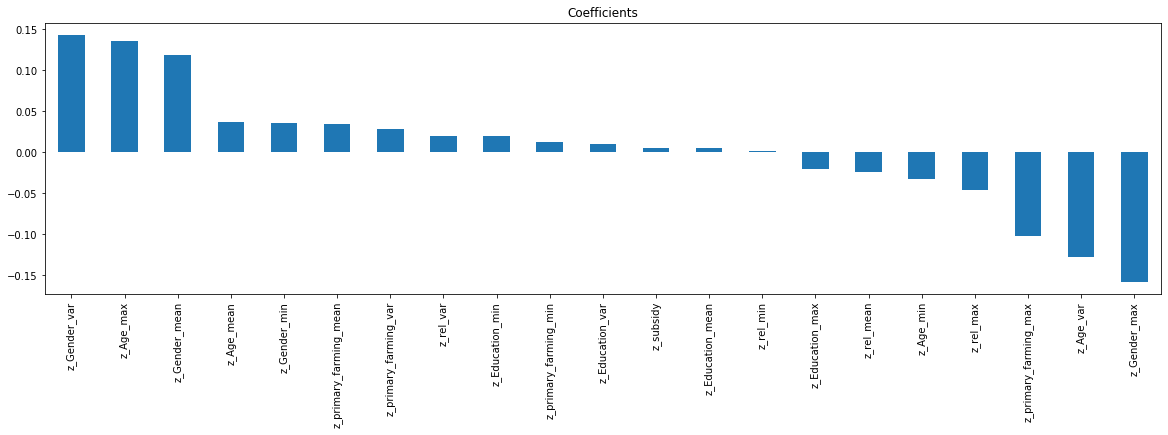

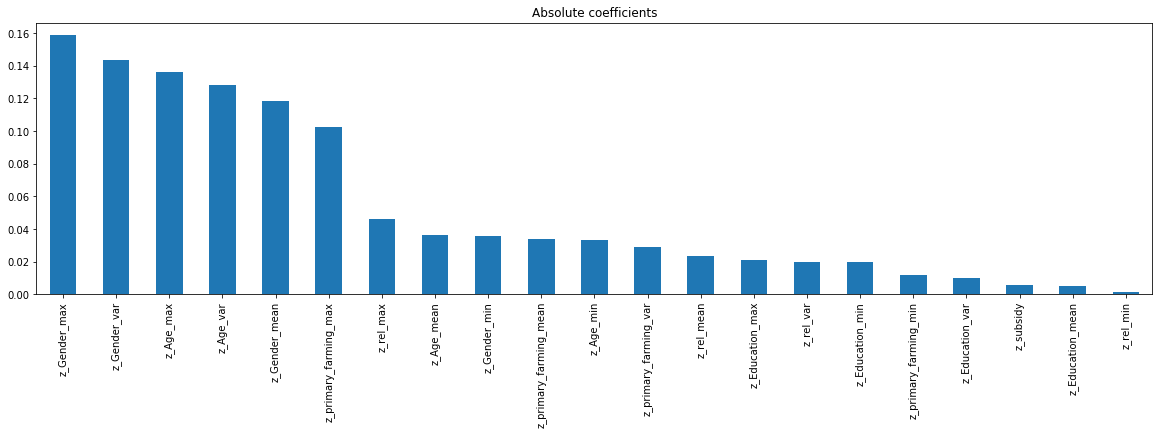

In [20]:
# plot coefficients
plt.figure(figsize=(20,5))
plt.title('Coefficients')
results.params.iloc[1:].sort_values(ascending=False).plot(kind='bar')
plt.show()

# plot absolute coefficients
plt.figure(figsize=(20,5))
plt.title('Absolute coefficients')
results.params.iloc[1:].abs().sort_values(ascending=False).plot(kind='bar')
plt.show()

## Heteroscedasticity Plot

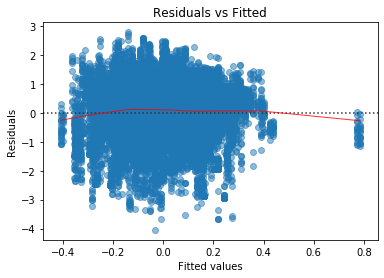

In [21]:
# model fitted values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid
# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = results.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = results.get_influence().cooks_distance[0]
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, data[response_var], data=data[explanatory_var],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

## Reduction in R2 if a variable is removed

In [22]:
orig_r2 = results.rsquared
for var in explanatory_var:
    temp_explanatory_var = explanatory_var.copy()
    temp_explanatory_var.remove(var)
    formula = response_var + ' ~ '
    for temp_var in temp_explanatory_var:
        formula += temp_var + ' + '
    formula = formula[:-3]
    temp_model = smformula.ols(formula, data=data).fit()
    print(var, temp_model.rsquared-results.rsquared)

z_Age_mean -0.00014509788944272461
z_Age_max -0.0015252396293321535
z_Age_min -0.00015829371072306753
z_Age_var -0.0021159025432715417
z_Education_mean -4.546309302133622e-06
z_Education_max -6.6438478888875e-05
z_Education_min -0.00010123629738501005
z_Education_var -2.329760421093674e-05
z_Gender_mean -0.004419499199145971
z_Gender_max -0.002921888333093925
z_Gender_min -0.00025517261880403375
z_Gender_var -0.002243212159046548
z_primary_farming_mean -0.00026958862657788796
z_primary_farming_max -0.0017845262255484773
z_primary_farming_min -1.2573093850054562e-05
z_primary_farming_var -8.52689360097969e-05
z_rel_mean -0.00013385222389883378
z_rel_var -9.57620702168871e-05
z_rel_min -2.615248720916341e-07
z_rel_max -0.0006733983040398961
z_subsidy -2.9469073491883435e-05


## Relative weights analysis

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 <a list of 21 Text xticklabel objects>)

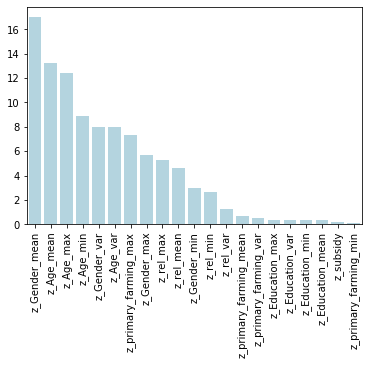

In [23]:
num_drivers = len(explanatory_var)
# Get a correlation between all of the dependent and independent variables.
corr_matrix = data[[response_var]+explanatory_var].apply(pd.to_numeric, errors = 'coerce').corr()
corr_Xs = corr_matrix.iloc[1:, 1:].copy()
corr_Xy = corr_matrix.iloc[1:, 0].copy()
# Create orthogonal predictors using eigenvectors and eigenvalues on the correlation matrix, creating a diagonal matrix
# of the square root of eigenvalues. This gets around the issue of multi-collinearity.
w_corr_Xs, v_corr_Xs = np.linalg.eig(corr_Xs)
diag_idx = np.diag_indices(len(corr_Xs))
diag = np.zeros((num_drivers, num_drivers), float)
diag[diag_idx] = w_corr_Xs
delta = np.sqrt(diag)
# Multiply the eigenvector matrix and its transposition. This allows us to treat X as the set of dependent variables, 
# regressing X onto matrix Z — itself the orthogonal counterpart of X having the least squared error. To get the partial 
# effect of each independent variable, we apply matrix multiplication to the inverse and correlation matricies.
coef_xz = v_corr_Xs @ delta @ v_corr_Xs.transpose()
coef_yz = np.linalg.inv(coef_xz) @ corr_Xy
# We then calculate the relative weight as the multiplication of the matrix in Step 2 and step 3. 
# The normalized version is then the percentage of r2 that these account for.
# Also, the sum of the squares of coef_yz above should add up to the total R2
r2 = sum(np.square(coef_yz))
raw_relative_weights = np.square(coef_xz) @ np.square(coef_yz)
normalized_relative_weights = (raw_relative_weights/r2)*100
idx = np.argsort(normalized_relative_weights)[::-1]
sns.barplot(x=corr_matrix.columns[1:][idx], y=np.sort(normalized_relative_weights)[::-1], color="lightblue")
plt.xticks(rotation=90)

## Scatter/regression plots for mean response_var grouped by explanatory variable

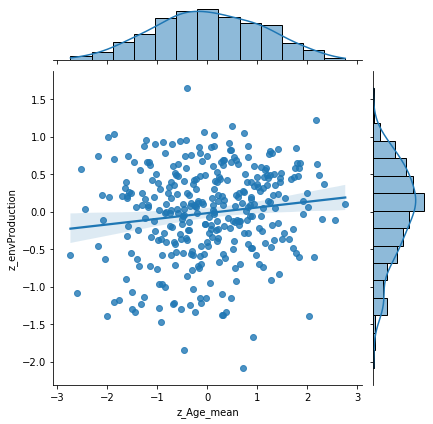

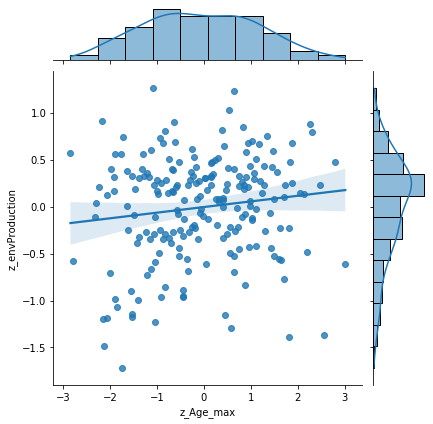

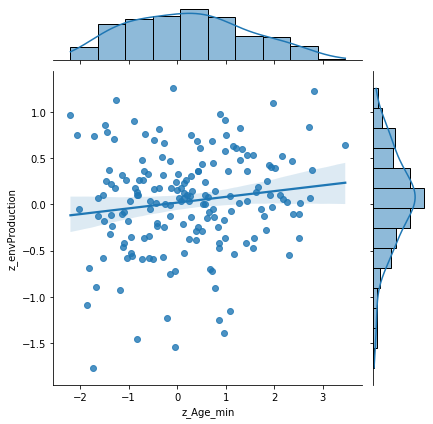

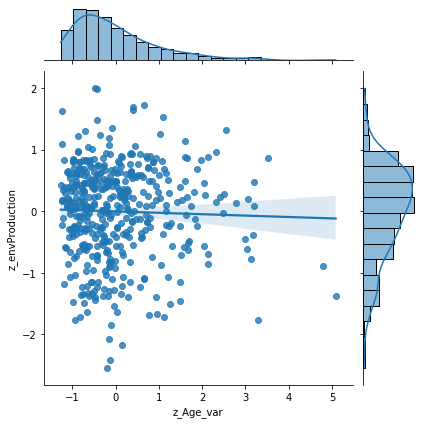

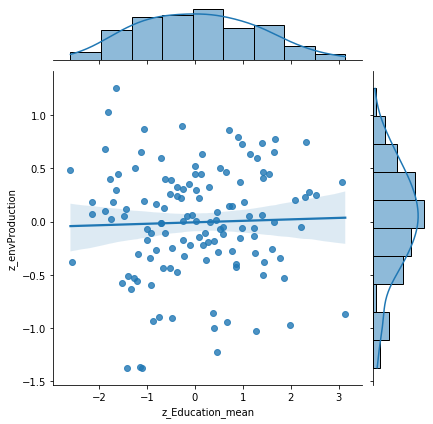

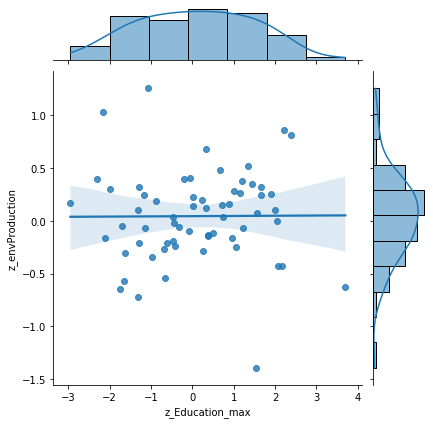

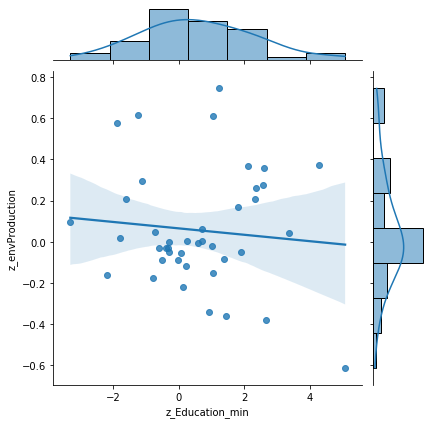

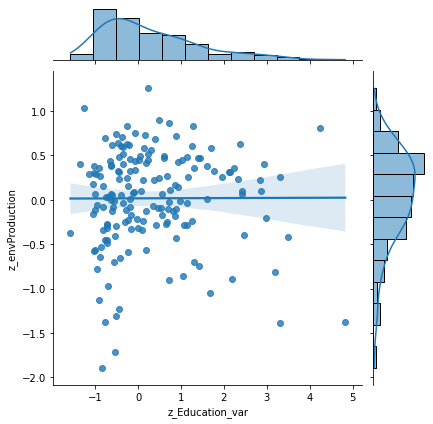

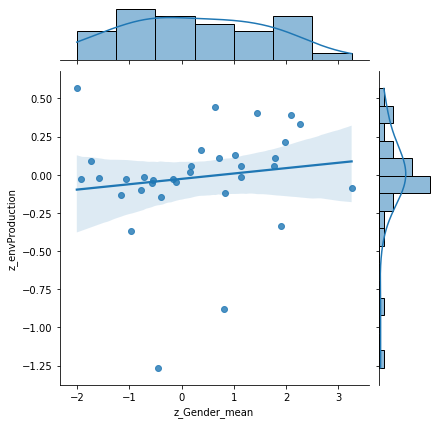

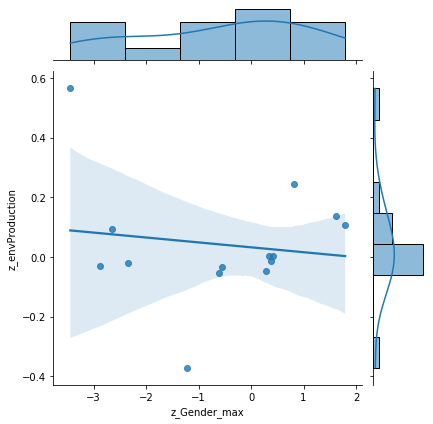

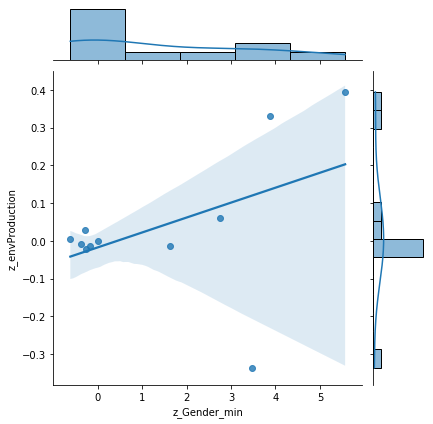

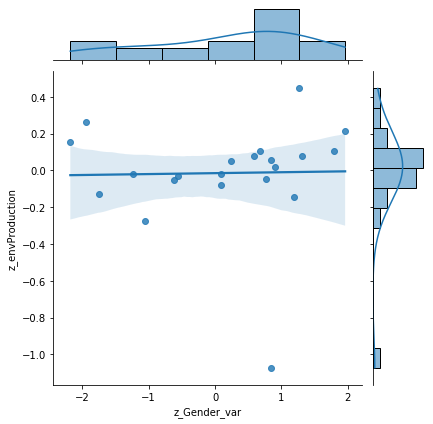

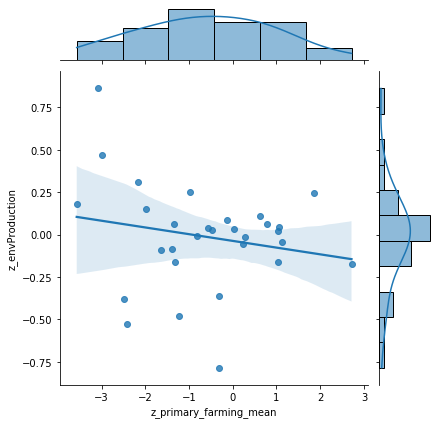

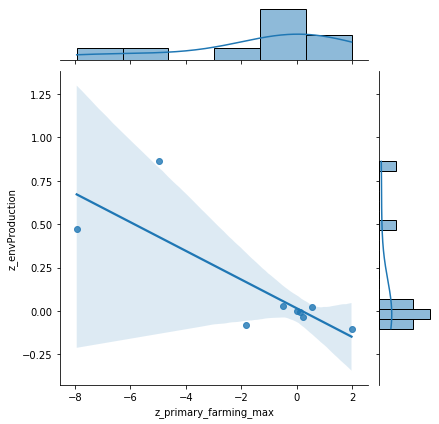

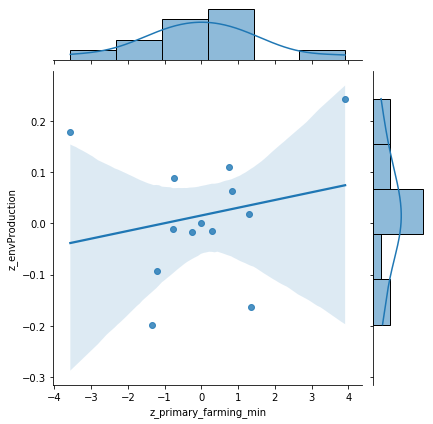

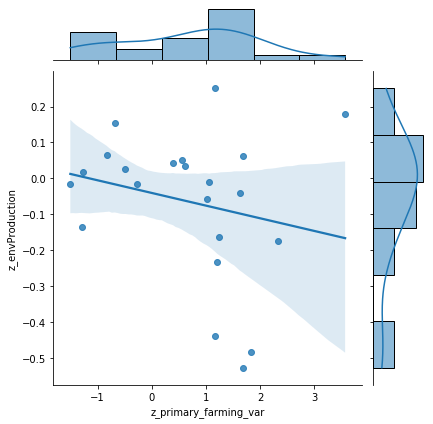

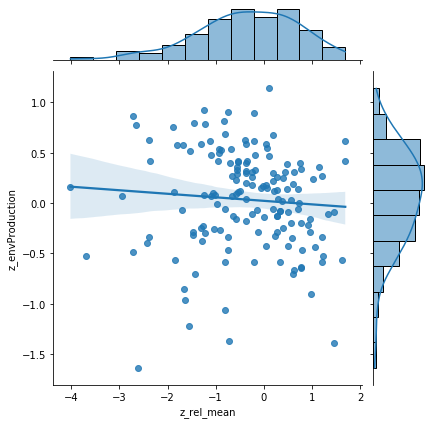

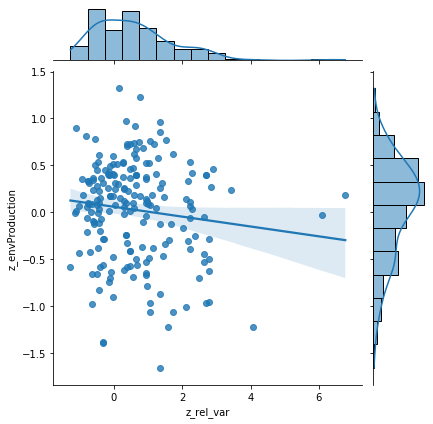

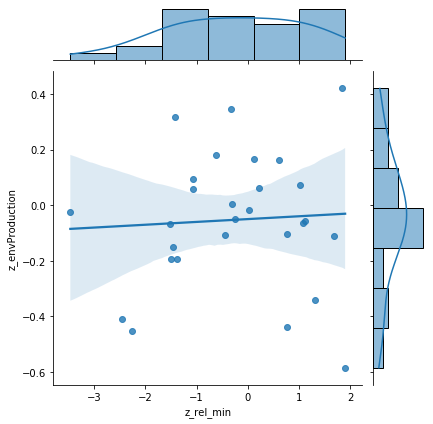

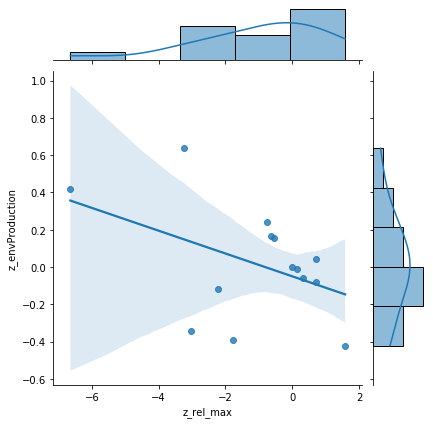

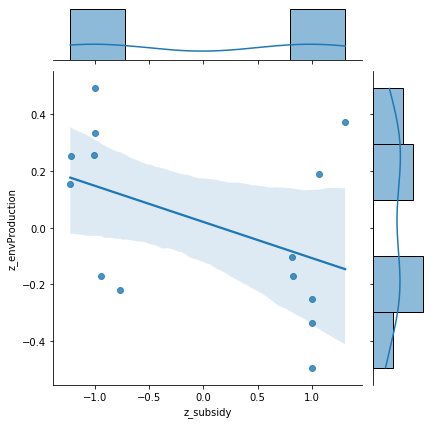

In [24]:
for var in explanatory_var:
    df = data[[var, response_var]].groupby(var).mean().reset_index()
    sns.jointplot(x=var, y=response_var, data=df, kind='reg')
    plt.show()

## Moving average and cubic regression plot for response_var against explanatory variable

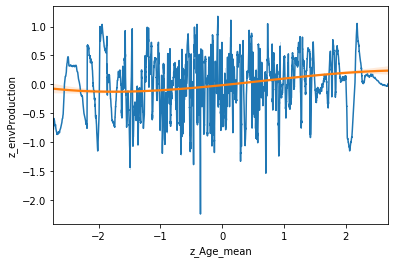

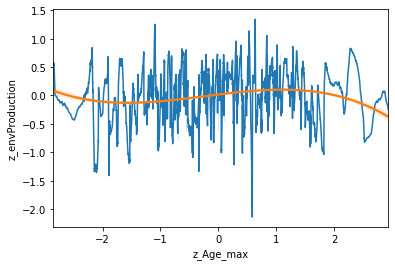

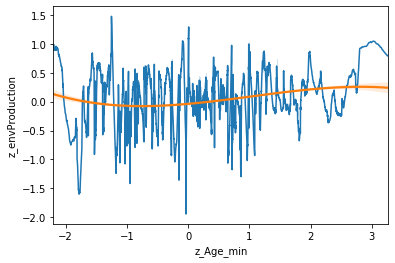

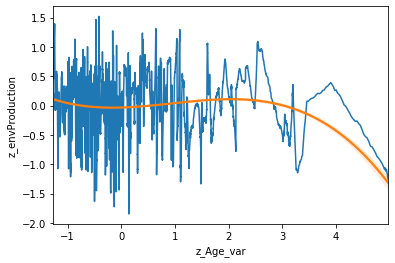

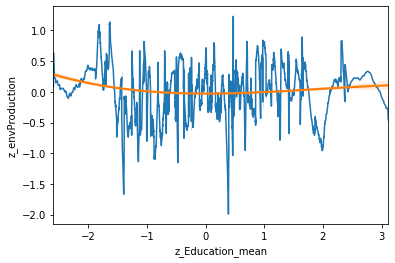

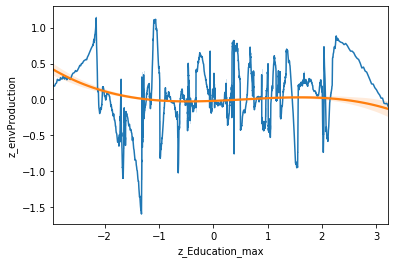

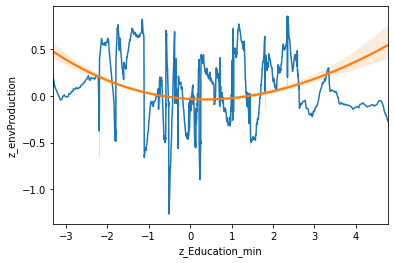

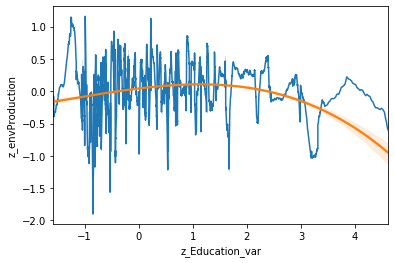

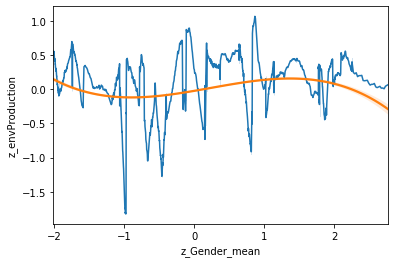

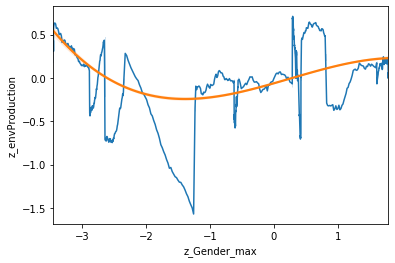

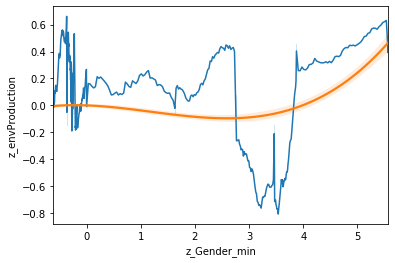

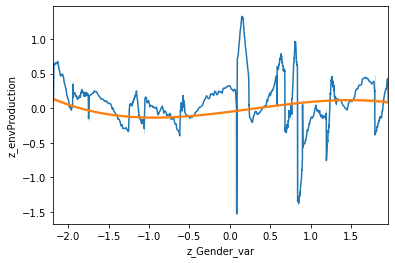

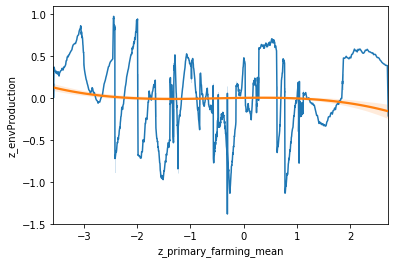

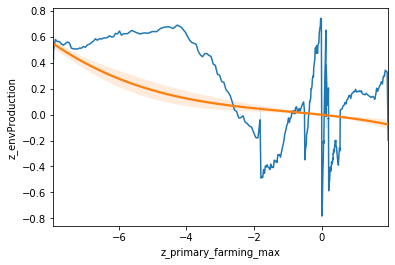

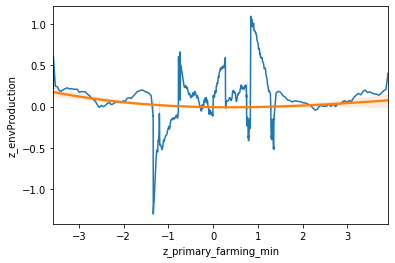

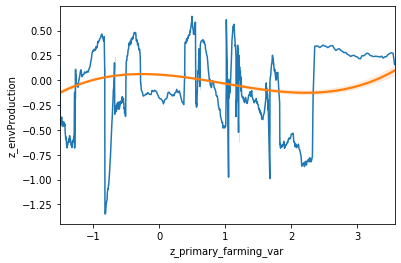

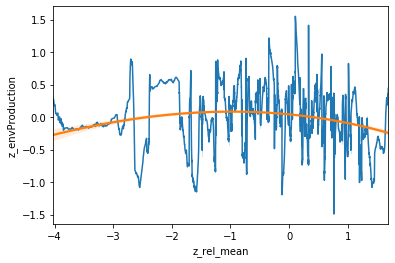

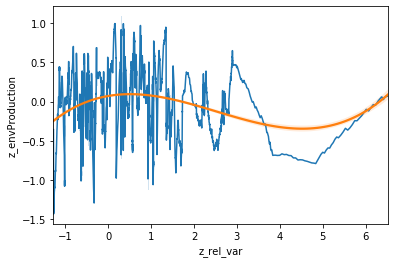

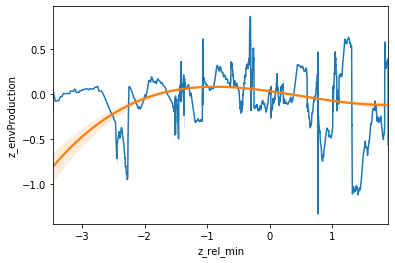

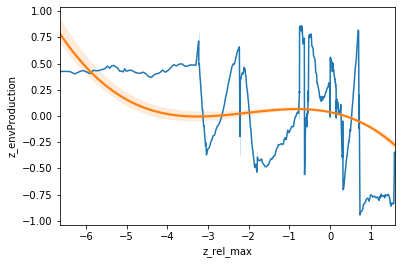

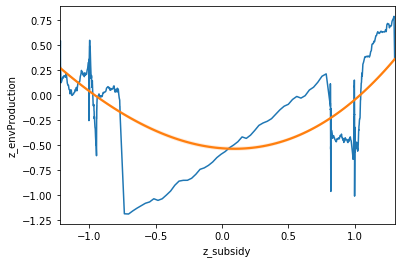

In [25]:
for var in explanatory_var:
    df = data[[var, response_var]].sort_values(by=var).rolling(window=50, min_periods=1).mean()
    sns.lineplot(x=var, y=response_var, data=df)
    sns.regplot(x=var, y=response_var, data=df, fit_reg=True, order=3, scatter=False)
    plt.show()

## Country-wise distributions of explanatory variable

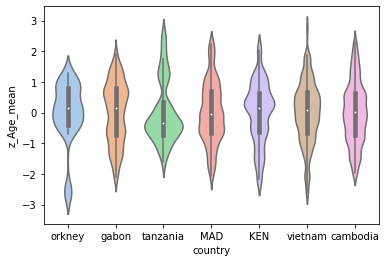

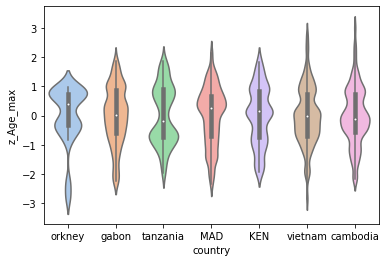

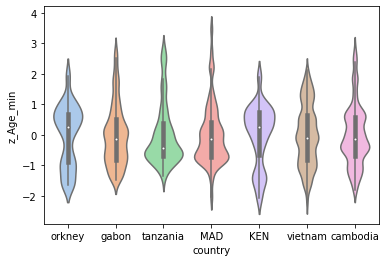

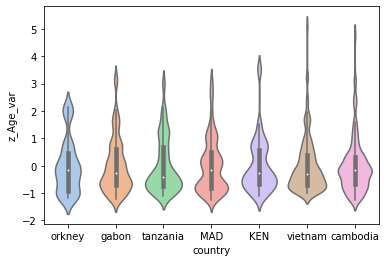

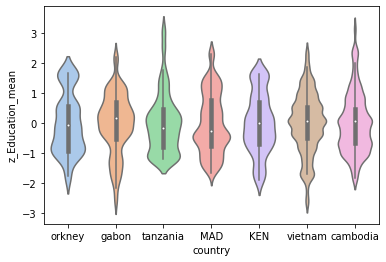

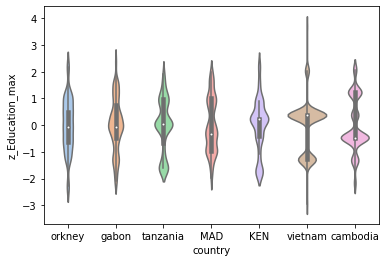

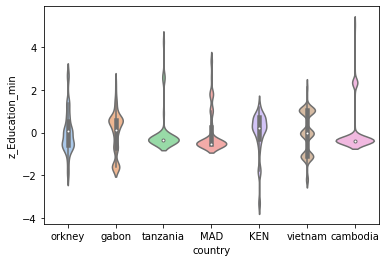

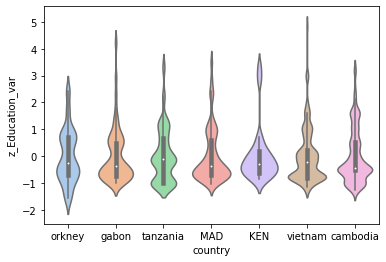

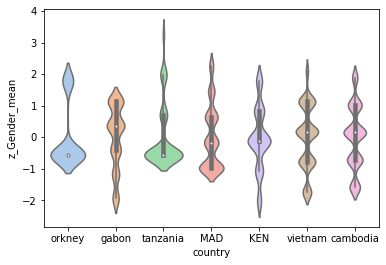

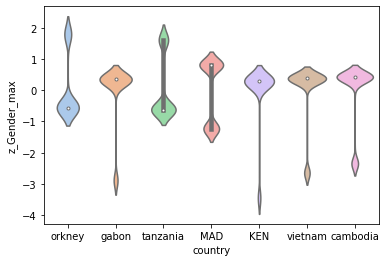

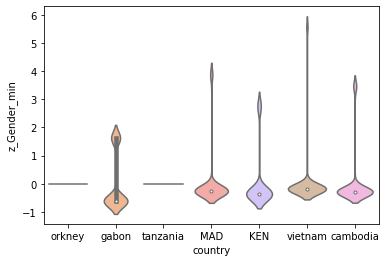

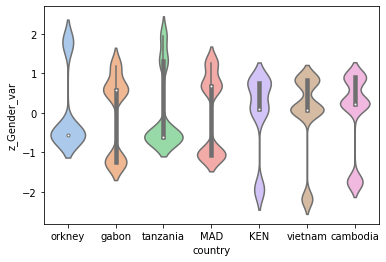

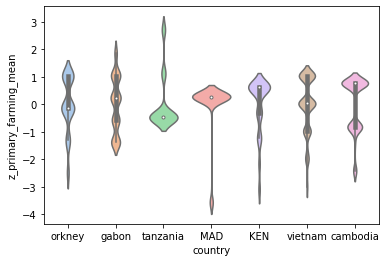

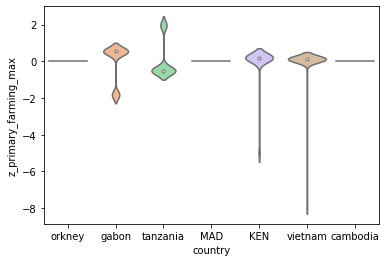

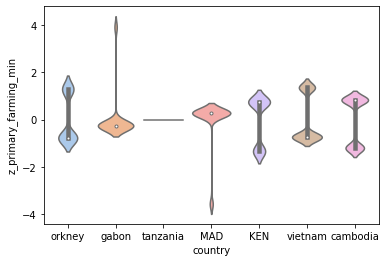

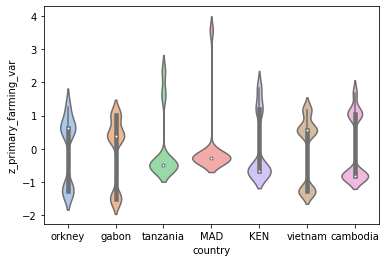

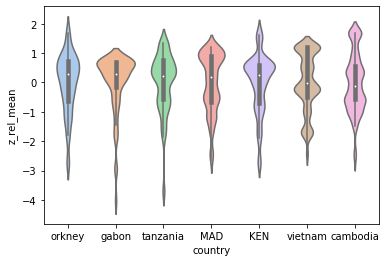

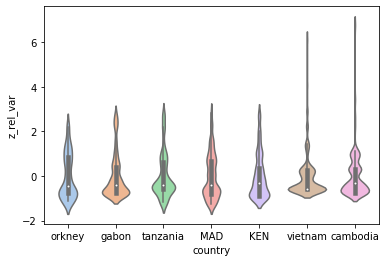

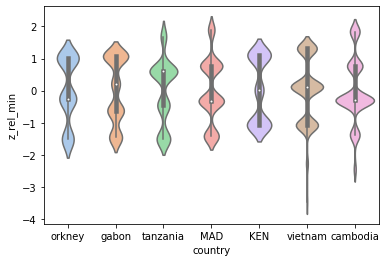

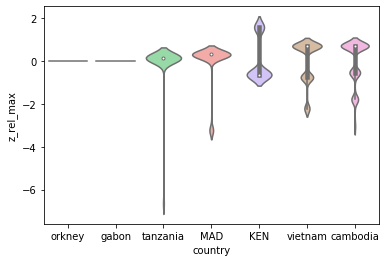

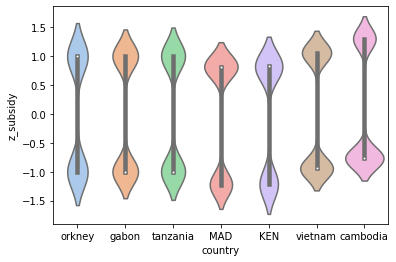

In [26]:
for var in explanatory_var:
    #df = data[[var, 'country']].groupby('country').boxplot(figsize=(12,4), layout=(1,7))
    sns.violinplot('country', var, data=data, palette='pastel')
    plt.show()

In [27]:
"""from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = StandardScaler().fit_transform(data[explanatory_var])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf.loc[:, 'principal component 1'],
           principalDf.loc[:, 'principal component 2'],
           c = data[response_var], s = 10, cmap='Blues')
ax.grid()"""

"from sklearn.preprocessing import StandardScaler\nfrom sklearn.decomposition import PCA\n\nx = StandardScaler().fit_transform(data[explanatory_var])\npca = PCA(n_components=2)\nprincipalComponents = pca.fit_transform(x)\nprincipalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])\n\nfig = plt.figure(figsize = (8,8))\nax = fig.add_subplot(1,1,1) \nax.set_xlabel('Principal Component 1', fontsize = 15)\nax.set_ylabel('Principal Component 2', fontsize = 15)\nax.set_title('2 component PCA', fontsize = 20)\nax.scatter(principalDf.loc[:, 'principal component 1'],\n           principalDf.loc[:, 'principal component 2'],\n           c = data[response_var], s = 10, cmap='Blues')\nax.grid()"

In [28]:
"""# calculating beta coefficients from coefficients
beta_coef = []
for var in results.params.index.values[1:]:
    beta_coef.append(results.params[var]*(data[var].std(ddof=0)/data[response_var].std(ddof=0)))
beta_coef = pd.DataFrame({'params':results.params.index.values[1:], 'coefs':beta_coef}).sort_values('coefs', ascending=False)
plt.figure(figsize=(20,5))
plt.bar('params', 'coefs', data=beta_coef)
plt.xticks(rotation=90)
plt.show()"""

"# calculating beta coefficients from coefficients\nbeta_coef = []\nfor var in results.params.index.values[1:]:\n    beta_coef.append(results.params[var]*(data[var].std(ddof=0)/data[response_var].std(ddof=0)))\nbeta_coef = pd.DataFrame({'params':results.params.index.values[1:], 'coefs':beta_coef}).sort_values('coefs', ascending=False)\nplt.figure(figsize=(20,5))\nplt.bar('params', 'coefs', data=beta_coef)\nplt.xticks(rotation=90)\nplt.show()"